In [64]:
import numpy as np
import ast
import math
import random
import logging
import itertools
import time
from functools import partial
import matplotlib.pyplot as plt

from Robot import Robot
from World import World, generate_environment, generate_information_model, generate_robots, run_experiment

logging.captureWarnings(True)
logging.getLogger().setLevel("ERROR")

# Policy
The implementation of a policy for the robot. It can be a simple path following policy for a robot, or it can encompass something complex, like an RL model.

In [1]:
class Policy:
    def __init__(self, name, env, robot):
        self.name = name
        self.env = env
        self.robot = robot
        
    def act(self, delta_t):
        """Act over the time of delta T. When implemented, it should add an action to be executed to
        the robot's action queue - it is not supposed to execute it here"""        
        pass
    
    def __str__(self):
        return self.name

In [66]:
class AbstractWaypointPolicy(Policy):
    """The ancestor of all the policies that are based on choosing waypoints"""
    
    ##def __init__(self, name, env, robot):
    ##    super().__init__("AbstractWaypointPolicy", env, robot)
    
    def move_towards_location(self, targetx, targety, vel, delta_t):
        """Schedule the actions to move the robot towards a target location. Returns true 
        if the robot will reach that location as the result of this step and false otherwise"""
        deltax = targetx - self.robot.x
        deltay = targety - self.robot.y
        veclength = np.linalg.norm([deltax, deltay])
        logging.debug(f"veclength {veclength}")
        if veclength == 0: # if we are there, stay there 
            self.robot.add_action("vel [0, 0]")
            return True
        if veclength <= self.vel * delta_t: # if we are closer than the velocity, then just go there
            logging.debug(f"We are there so go there [{targetx}, {targety}]")
            self.robot.add_action("vel [0, 0]")
            self.robot.add_action(f"loc [{targetx}, {targety}]")
            return True
        # move towards the location with the specified velocity
        #vel_x = min(vel * deltax / veclength, delta_t * deltax)
        #vel_y = min(vel * deltay / veclength, delta_t * deltay)
        vel_x = vel * deltax / veclength
        vel_y = vel * deltay / veclength
        action = f"vel [{vel_x}, {vel_y}]"
        logging.debug(f"move_towards_location setting action = {action}")
        self.robot.add_action(action)
        return False

In [67]:
class GoToLocationPolicy(AbstractWaypointPolicy):
    """This is a simple policy that make the robot go to a certain location."""
    def __init__(self, env, robot, locx, locy, vel):
        super().__init__("GoToPolicy", env, robot)
        self.locx, self.locy, self.vel = locx, locy, vel
        
    def act(self, delta_t):
        """ Head towards locx, locy with a velocity vel"""
        ##logging.debug("HERE")
        self.move_towards_location(self.locx, self.locy, self.vel, delta_t)

In [68]:
class FollowPathPolicy(AbstractWaypointPolicy):
    """A policy that makes a robot follow a certain path specified as a series of waypoints. 
    If repeat is true, it repeats the path indefinitely."""
    def __init__(self, env, robot, vel, waypoints, repeat = False):
        super().__init__("FollowPathPolicy", env, robot)
        self.waypoints = waypoints.copy()
        self.vel = vel
        self.currentwaypoint = 0
        self.repeat = repeat
        
    def act(self, delta_t):
        ## if we are done with the movement, don't do anything
        if self.currentwaypoint == -1:
            return
        ## move towards the current waypoint
        wp = self.waypoints[ self.currentwaypoint ]
        done = self.move_towards_location(wp[0], wp[1], self.vel, delta_t)
        if done:
            self.currentwaypoint = self.currentwaypoint + 1
            if self.currentwaypoint == len(self.waypoints):
                if self.repeat: 
                    self.currentwaypoint = 0
                else:
                    self.currentwaypoint = -1

In [69]:
class RandomWaypointPolicy(AbstractWaypointPolicy):
    """A policy that makes the robot follow a random waypoint behavior within a specified region
    using a constant velocity.
    The region is specied with the low_point and high_point each of them having (x,y) formats """
    def __init__(self, env, robot, vel, low_point, high_point, seed):
        super().__init__("RandomWaypointPolicy", env, robot)
        self.random = np.random.default_rng(seed)
        self.vel = vel
        self.low_point = low_point
        self.high_point = high_point
        self.nextwaypoint = None
                
    def act(self, delta_t):
        """Moves towards the chosen waypoint. If the waypoint is """
        if self.nextwaypoint == None:
            x = self.random.uniform(self.low_point[0], self.high_point[0])
            y = self.random.uniform(self.low_point[1], self.high_point[1])
            self.nextwaypoint = [x, y]
        done = self.move_towards_location(self.nextwaypoint[0], self.nextwaypoint[1], self.vel, delta_t)
        if done:
            self.nextwaypoint = None

## Experiments for trying out the different policies

In [70]:
robot = Robot("Robi", 20, 30, 0)
robot.policy = GoToLocationPolicy(None, robot, 40, 40, 0.6)
#print(robot)
#for i in range(40):
#    robot.enact_policy()
#    robot.proceed()
#    print(robot)

print("-------------- Robur -------------------")
robot = Robot("Robur", 4, 8, 0)
robot.policy = RandomWaypointPolicy(None, robot, 1, [0,0], [10, 10], seed = 11)
print(robot)
for i in range(40):
    robot.enact_policy()
    robot.proceed()
    print(robot)


robot = Robot("R2D3", 5, 9, 0)
robot.policy = FollowPathPolicy(None, robot, 1, [[0,0], [5, 5], [10,0]], repeat = True)
    

-------------- Robur -------------------
Robur --> loc = [x:4.00,y:8.00,alt:0.00] vel = [x:0.00,y:0.00,alt:0.00]
Robur --> loc = [x:3.33,y:7.26,alt:0.00] vel = [x:-0.67,y:-0.74,alt:0.00]
Robur --> loc = [x:2.66,y:6.52,alt:0.00] vel = [x:-0.67,y:-0.74,alt:0.00]
Robur --> loc = [x:1.99,y:5.77,alt:0.00] vel = [x:-0.67,y:-0.74,alt:0.00]
Robur --> loc = [x:1.32,y:5.03,alt:0.00] vel = [x:-0.67,y:-0.74,alt:0.00]
Robur --> loc = [x:1.29,y:4.99,alt:0.00] vel = [x:0.00,y:0.00,alt:0.00]
Robur --> loc = [x:1.99,y:4.29,alt:0.00] vel = [x:0.71,y:-0.71,alt:0.00]
Robur --> loc = [x:2.70,y:3.58,alt:0.00] vel = [x:0.71,y:-0.71,alt:0.00]
Robur --> loc = [x:3.41,y:2.88,alt:0.00] vel = [x:0.71,y:-0.71,alt:0.00]
Robur --> loc = [x:4.12,y:2.17,alt:0.00] vel = [x:0.71,y:-0.71,alt:0.00]
Robur --> loc = [x:4.83,y:1.47,alt:0.00] vel = [x:0.71,y:-0.71,alt:0.00]
Robur --> loc = [x:5.54,y:0.76,alt:0.00] vel = [x:0.71,y:-0.71,alt:0.00]
Robur --> loc = [x:6.01,y:0.29,alt:0.00] vel = [x:0.00,y:0.00,alt:0.00]
Robur -->

In [71]:
class InformationGreedyPolicy(AbstractWaypointPolicy):
    """A policy which makes the robot choose its next waypoint to be the one with the 
    largest information value from an square area of radius span around the current location"""
    def __init__(self, robot, vel, span = 5):
        super().__init__("InformationGreedyPolicy", robot.env, robot)
        self.vel = vel
        self.nextwaypoint = None
        self.span = span
                
    def act(self, delta_t):
        """Moves towards the chosen waypoint. If the waypoint had been reached, chooses the next waypoint
        which is the one with the highest uncertainty value"""
        if self.nextwaypoint == None:
            feasible_waypoints = self.generate_feasible_waypoints()
            # waypoint_values = [self.robot.im.estimate_voi(x) for x in feasible_waypoints]            
            # tcurrent = time.perf_counter()
            waypoint_values = [self.robot.im.uncertainty[x[0],x[1]] for x in feasible_waypoints]       
            # print(f"time spent here {time.perf_counter() - tcurrent}")
            bestindex = np.argmax(waypoint_values)            
            self.nextwaypoint = feasible_waypoints[bestindex]
        done = self.move_towards_location(self.nextwaypoint[0], self.nextwaypoint[1], self.vel, delta_t)
        if done:
            self.nextwaypoint = None
            
    def generate_feasible_waypoints(self):
        # generate all the feasible waypoints: the points in a rectangular area of extent span from 
        # the current points
        currentx = int(self.robot.x)
        currenty = int(self.robot.y)
        rangex = range(max(0, currentx - self.span), min(currentx+self.span, self.robot.env.width))
        rangey = range(max(0, currenty - self.span), min(currenty+self.span, self.robot.env.height))
        val = itertools.product(rangex, rangey)
        return list(val)


In [72]:
### Debugging the InformationGreedyRobot

def generate_robots(world):
    robot = Robot(f"Greedy", 0, 0, 0, env=world.env, im=world.im)
    robot.policy = InformationGreedyPolicy(robot, vel = 1, span = 2)
    world.add_robot(robot)
    print(robot.env)

genim = partial(generate_information_model, 
                {"estimation_type": "gaussian-process"})
    
def run_experiment(genenv, genim, genrob):
    """Generates the environment, the model and the robots"""
    env = genenv()
    im = genim(env)
    world = World(env, im)
    genrob(world)
    record = []
    for t in range(100):
        world.enact_policy(1)
        world.proceed(1)
        ## this is where we get some kind of metric
        record.append(im.score(env))
    return world, record
    
world, record = run_experiment(generate_environment, genim, generate_robots)

In [79]:
def plot_robot_path(path):
    ## plotting in such a way as the plot gets lighter and ligher as we progress
    fig, ax = plt.subplots()
    arr = np.array(path)
    i = 0
    step = 5
    colorstep = 0.9 / (arr.shape[0] / step)
    for i, a in enumerate(range(0, arr.shape[0], step)):
        color = (i * colorstep, i * colorstep, i * colorstep)
        xs = arr[a:a+step+1, 0]
        ys = arr[a:a+step+1, 1]
        ax.plot(xs, ys, color=color)


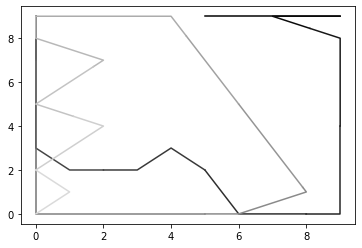

In [81]:
path = world.robots[0].location_history
plot_robot_path(path)

In [84]:
def generate_lawnmower(xmin, xmax, ymin, ymax, winds):
    """Generates a horizontal lawnmower path on the list """
    current = [xmin, ymin]
    ystep = (ymax - ymin) / (2 * winds)
    path = []
    path.append(current)
    for i in range(winds):
        path.append([xmax, current[1]])
        path.append([xmax, current[1]+ystep])
        path.append([xmin, current[1]+ystep])
        current = [xmin, current[1]+2 * ystep]
        path.append(current)
    path.append([xmax, current[1]])
    return path


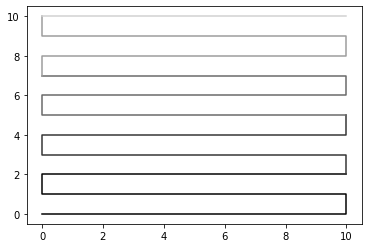

In [85]:
path = generate_lawnmower(0, 10, 0, 10, 5)
plot_robot_path(path)